Question 3

  3.1. Preprocess your data as necessary and perform sentiment analysis on the content column to categorize user reviews as
positive, neutral, or negative. Save the sentiments for each review in a new column called “Sentiment”


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [2]:
df = pd.read_csv(
  'data/chatgpt_reviews.csv',
  
  header=0,
  names=['reviewId', 'userName', 'content', 'score', 'thumpsUpCount', 'reviewCreated', 'date', 'appVersion'],
  parse_dates=True
)

In [3]:
df = df.dropna()

In [4]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis using Vader
def analyze_sentiment(text):
    if isinstance(text, str):
        scores = sid.polarity_scores(text)
        compound = scores['compound']
        
        # Classify sentiment
        if compound >= 0.05:
            return 'Positive'
        elif compound <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    else:
        return 'Neutral'  # Default for non-string values

# Apply sentiment analysis to the content column
df['Sentiment'] = df['content'].apply(analyze_sentiment)

In [5]:
df['Sentiment'].value_counts()

Sentiment
Positive    228043
Neutral      53572
Negative     13238
Name: count, dtype: int64

3.2. Using visualizations, highlight features or issues that are frequently mentioned in both positive and negative reviews.
Additionally, identify which aspects users seem to love about ChatGPT vs which features they dislike.


In [6]:
# Function to extract common words from text
def extract_words(text, sentiment):
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^\w\s]', '', text.lower())
    
    # Remove common stop words
    stop_words = ['the', 'and', 'is', 'in', 'it', 'to', 'i', 'this', 'that', 'for', 'a', 'of', 'with', 'on', 'my', 'me',
                 'you', 'your', 'very', 'but', 'not', 'have', 'has', 'had', 'are', 'was', 'were', 'be', 'been', 'being',
                 'an', 'can', 'will', 'just', 'do', 'does', 'did', 'so', 'no', 'yes', 'more', 'most', 'some', 'such',
                 'what', 'when', 'where', 'who', 'which', 'how', 'all', 'any', 'both', 'each', 'few', 'other', 'than',
                 'too', 'very', 'own', 'app', 'use', 'get', 'got', 'its', 'im', 'dont', 'like', 'good', 'great', 'best',
                 'nice', 'love', 'chat', 'gpt', 'chatgpt', 'ai']
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    
    return words

# Extract common words by sentiment
positive_words = []
negative_words = []
neutral_words = []

for _, row in df.iterrows():
    if row['Sentiment'] == 'Positive':
        positive_words.extend(extract_words(row['content'], 'Positive'))
    elif row['Sentiment'] == 'Negative':
        negative_words.extend(extract_words(row['content'], 'Negative'))
    else:
        neutral_words.extend(extract_words(row['content'], 'Neutral'))

# Count word frequencies
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

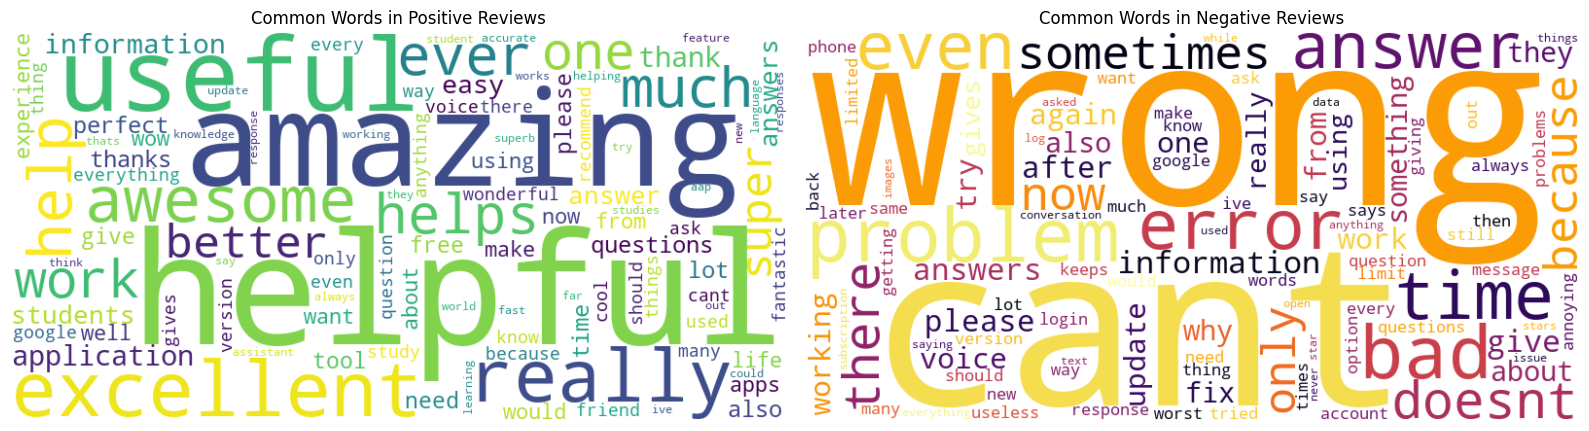

In [7]:
plt.figure(figsize=(16, 8))

# Positive word cloud
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='viridis').generate_from_frequencies(positive_word_counts)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Common Words in Positive Reviews')
plt.axis('off')

# Negative word cloud
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                              max_words=100, colormap='inferno').generate_from_frequencies(negative_word_counts)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Common Words in Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Extract top features from positive and negative reviews
top_positive = positive_word_counts.most_common(15)
top_negative = negative_word_counts.most_common(15)

C:\Users\tiset\AppData\Local\Temp\ipykernel_3956\3052877332.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_positive], y=[word[1] for word in top_positive], palette='viridis')
C:\Users\tiset\AppData\Local\Temp\ipykernel_3956\3052877332.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[0] for word in top_negative], y=[word[1] for word in top_negative], palette='inferno')


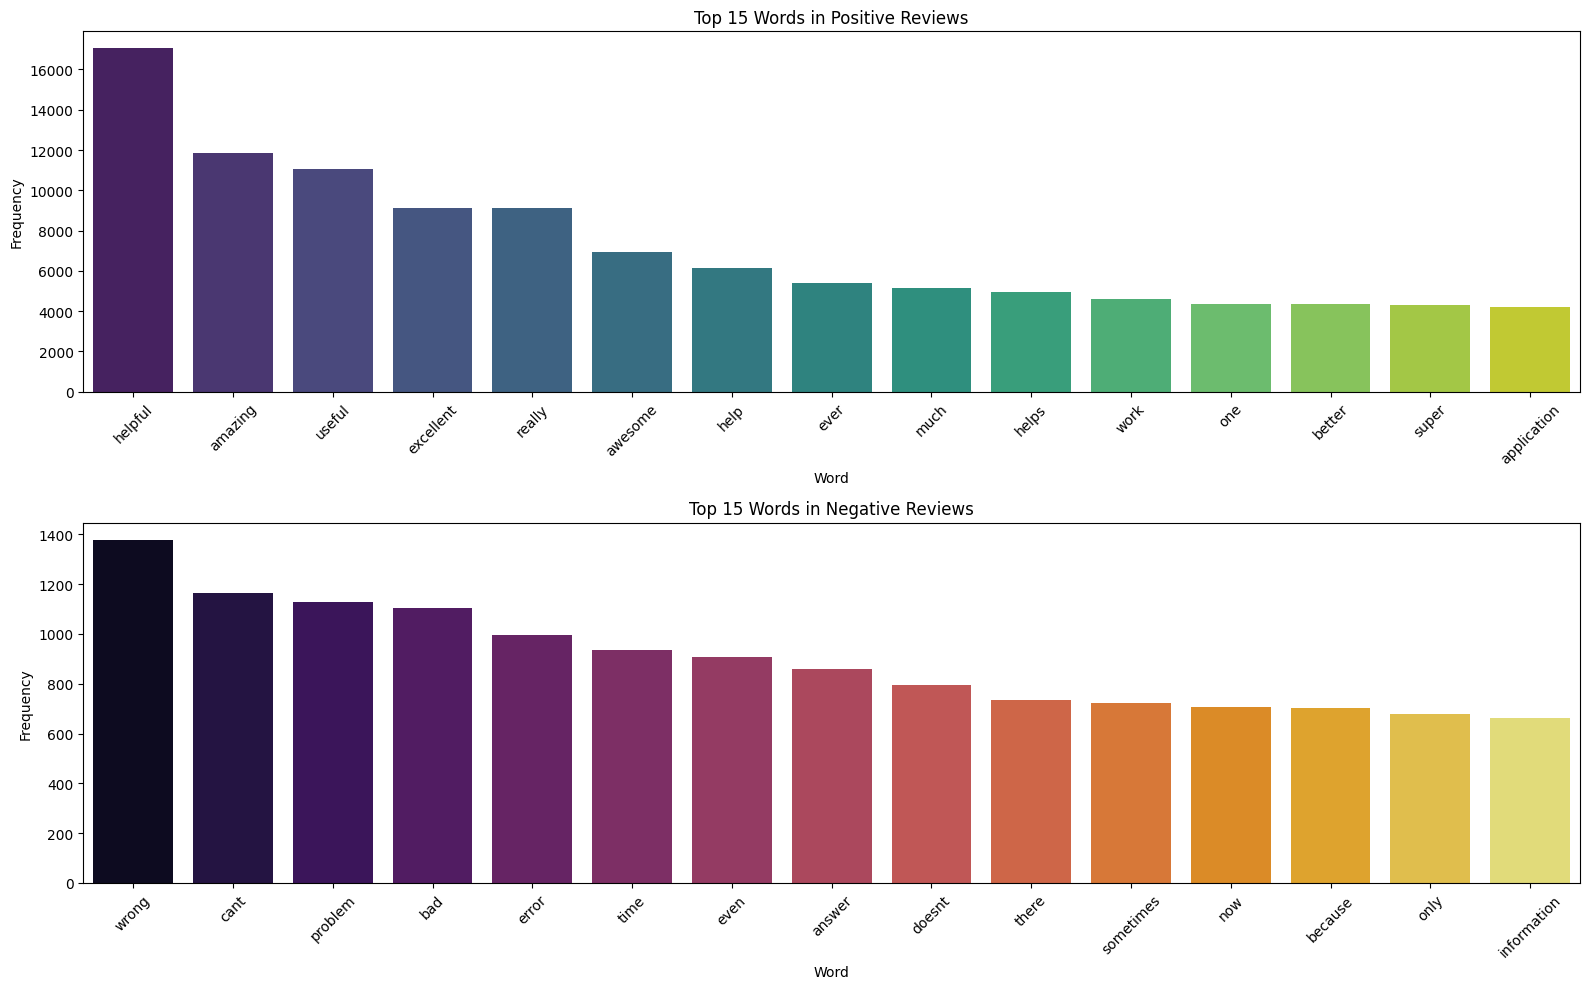

In [9]:
# Create bar charts for top words
plt.figure(figsize=(16, 10))

# Positive words
plt.subplot(2, 1, 1)
sns.barplot(x=[word[0] for word in top_positive], y=[word[1] for word in top_positive], palette='viridis')
plt.title('Top 15 Words in Positive Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Negative words
plt.subplot(2, 1, 2)
sns.barplot(x=[word[0] for word in top_negative], y=[word[1] for word in top_negative], palette='inferno')
plt.title('Top 15 Words in Negative Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

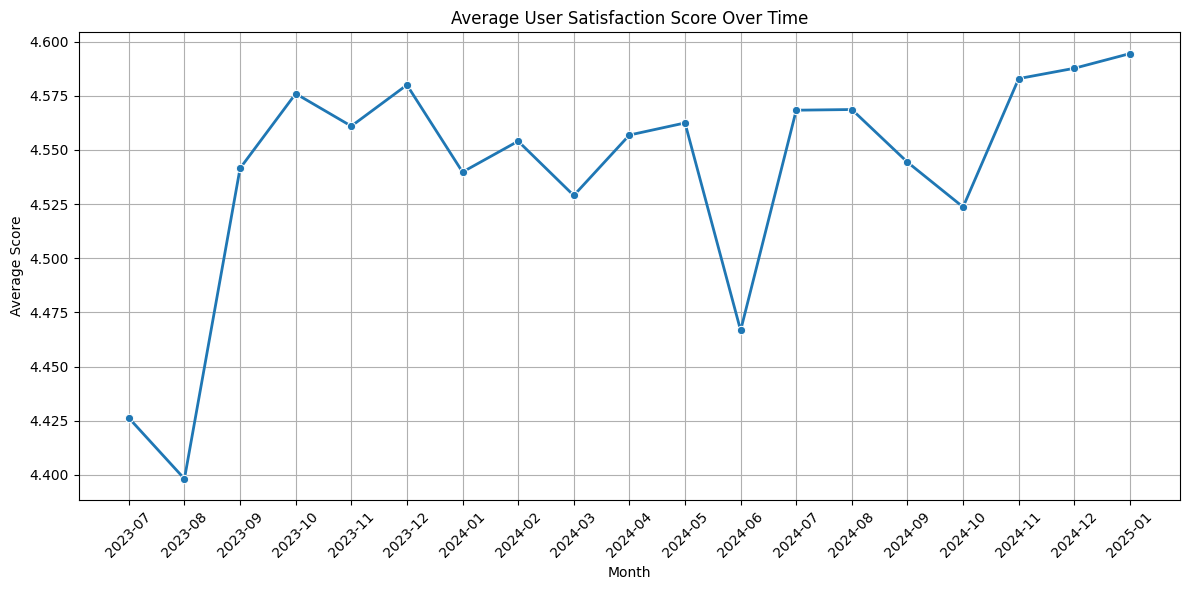

In [10]:
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y %H:%M')

# Analyze satisfaction over time
df['month'] = df['date'].dt.to_period('M')

monthly_scores = df.groupby('month')['score'].mean().reset_index()
monthly_scores['month'] = monthly_scores['month'].astype(str)

# Analyze sentiment over time
sentiment_over_time = df.groupby(['month', 'Sentiment']).size().unstack().fillna(0)
sentiment_over_time = sentiment_over_time.div(sentiment_over_time.sum(axis=1), axis=0) * 100

# Create a line plot for satisfaction over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_scores, x='month', y='score', marker='o', linewidth=2)
plt.title('Average User Satisfaction Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Sentiment Analysis of User Reviews**

The vast majority of reviews (76.52%, 228043) expressed positive sentiment, About 18.50%(53572) of reviews were classified as neutral.
Only 4.99% (13238) of reviews expressed negative sentiment. 

**Positive Features:**
- Helpfulness: Users praised how ChatGPT helps with various tasks, 
- User Experience: Terms like "amazing," "excellent," and "awesome" appeared frequently, indicating high satisfaction with the overall experience.

**Negative Features:**
- Memory Limitations: Complaints about ChatGPT forgetting context and shoeing errors.
- Occasional Inaccuracies: Some users reported receiving incorrect information or answers.

**User Satisfaction Trends Over Time**

Analyzing the average satisfaction scores over time revealed interesting patterns:

- Initial Low-rating: Low scores in 2023-07 and 2023-08
- High-rating: Then satisfaction scores were extremely high, likely reflecting  excitement around the technology.
-Slight Decline: Slight decline in 2024-06, which, may have becaused by pricing of software updates.
- Stabilization: In recent months, satisfaction scores have stabilized, suggesting that user expectations have adjusted to the capabilities and limitations of the platform.

Based on the sentiment analysis of ChatGPT reviews, GitHub should consider the following when developing its own chatbot:

**Strengths to Emulate:**
1. Educational: Github should emphasize educational content and assistance.
2. Conversation: Users appreciate ChatGPT's natural, conversational tone.
3. Understanding of context: Users value ChatGPT's ability to maintain context throughout a conversation.

**Weaknesses to Address:**
1. Technical Accuracy: GitHub should use its large code base to ensure higher accuracy for programming-related queries than ChatGPT can provide.
2. Problem solving: Github should try to solve the users specific problem and not offer generic answer  which not not be useful.
3. Specialized Knowledge: GitHub should ensure its chatbot has deep expertise in software development.
